In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import glob

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from scipy import signal
import matplotlib.animation as animation
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True)

# Load the Dataset

In [2]:
videoDF = pd.read_csv('input/youtube_faces_with_keypoints_full.csv')
videoDF.head()

,videoID,personName,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
0,Alison_Lohman_0,Alison_Lohman,228.0,213.0,240.0,90.150000,6.0
1,Alison_Lohman_1,Alison_Lohman,248.0,201.0,79.0,108.417722,6.0
2,Alison_Lohman_2,Alison_Lohman,335.0,308.0,136.0,122.161765,6.0
3,Alison_Lohman_3,Alison_Lohman,151.0,110.0,53.0,58.000000,6.0
4,Alison_Lohman_4,Alison_Lohman,236.0,228.0,147.0,91.680272,6.0


# **Exploratory Data Analysis**:

# Dataset Overview

In [3]:
print(f"Dataset shape: {videoDF.shape}")

Dataset shape: (2194, 7)


In [4]:
videoDF.describe()

,imageHeight,imageWidth,videoDuration,averageFaceSize,numVideosForPerson
count,2194.000000,2194.000000,2194.000000,2194.000000,2194.000000
mean,210.290337,195.633546,118.686873,94.887054,2.929809
std,64.514279,67.464967,71.806225,36.811662,0.959554
min,81.000000,74.000000,42.000000,40.220339,2.000000
25%,163.000000,147.000000,59.000000,67.337232,2.000000
50%,203.000000,185.000000,88.000000,87.578507,3.000000
75%,245.000000,234.000000,178.000000,114.550184,4.000000
max,480.000000,494.000000,240.000000,247.862745,6.000000


In [5]:
# There are no NaNs
videoDF.isna().sum()

videoID               0
personName            0
imageHeight           0
imageWidth            0
videoDuration         0
averageFaceSize       0
numVideosForPerson    0
dtype: int64

In [6]:
#Count the number of still images
print(f"Total number of frames/images: {videoDF['videoDuration'].sum():.0f}")

Total number of frames/images: 260399


In [7]:
print(f"Number of Videos: {videoDF.shape[0]}")

namelist = videoDF['personName'].unique()
print(f"Number of Unique Individuals: {len(namelist)}")

Number of Videos: 2194
Number of Unique Individuals: 828


In [8]:
# Number of videos per each person in dataset
videoDF.groupby(['personName'])['videoID'].count().sort_values(ascending=False)

personName
Kevin_Spacey           6
Alison_Lohman          6
Robert_F_Kennedy_Jr    6
Lauren_Hutton          6
Kim_Gandy              5
                      ..
Ham_Pong-sil           2
Zoran_Djindjic         2
Alberto_Acosta         1
Hana_Sadiq             1
Nobuyuki_Idei          1
Name: videoID, Length: 828, dtype: int64

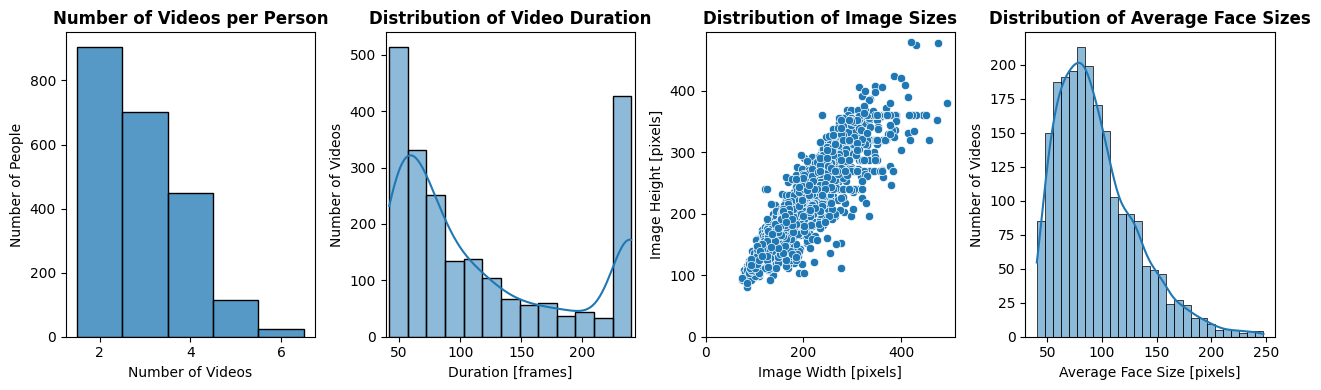

In [9]:
_, axes = plt.subplots(1, 4, figsize=(13,4))

sns.histplot(videoDF['numVideosForPerson'], bins=0.5+np.arange(videoDF['numVideosForPerson'].min()-1, videoDF['numVideosForPerson'].max()+1), ax=axes[0])
axes[0].set_title('Number of Videos per Person', fontweight='bold')
axes[0].set_xlabel('Number of Videos')
axes[0].set_ylabel('Number of People')

sns.histplot(videoDF['videoDuration'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Video Duration', fontweight='bold')
axes[1].set_xlabel('Duration [frames]')
axes[1].set_ylabel('Number of Videos')
axes[1].set_xlim(videoDF['videoDuration'].min()-3, videoDF['videoDuration'].max()+3)

sns.scatterplot(x='imageWidth', y='imageHeight', data=videoDF, ax=axes[2])
axes[2].set_title('Distribution of Image Sizes', fontweight='bold')
axes[2].set_xlabel('Image Width [pixels]')
axes[2].set_ylabel('Image Height [pixels]')
axes[2].set_xlim(0, videoDF['imageWidth'].max()+15)
axes[2].set_ylim(0, videoDF['imageHeight'].max()+15)

sns.histplot(videoDF['averageFaceSize'], kde=True, bins=28, ax=axes[3])
axes[3].set_title('Distribution of Average Face Sizes', fontweight='bold')
axes[3].set_xlabel('Average Face Size [pixels]')
axes[3].set_ylabel('Number of Videos')

plt.tight_layout()
plt.show()

# Locate the Video Files for Use

#### Glob is an extension of Python that assigns a filepath to each file in a given directory so that it can be called by the program.

In [10]:
# create array with all full file paths
npzFilesFullPath = glob.glob('input/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/*.npz')

npzFilesFullPath=np.append(npzFilesFullPath,glob.glob('input/youtube_faces_with_keypoints_full_2/youtube_faces_with_keypoints_full_2/*.npz'))
npzFilesFullPath=np.append(npzFilesFullPath,glob.glob('input/youtube_faces_with_keypoints_full_3/youtube_faces_with_keypoints_full_3/*.npz'))
npzFilesFullPath=np.append(npzFilesFullPath,glob.glob('input/youtube_faces_with_keypoints_full_4/youtube_faces_with_keypoints_full_4/*.npz'))

npzFilesFullPath = [path.replace('\\', '/') for path in npzFilesFullPath]

print("Example of path:")
print(npzFilesFullPath[0])

# remove the .npz file extension
videoIDs = [x.split('/')[-1].split('.')[0] for x in npzFilesFullPath]
# create a dictionary that maps videoIDs to full file paths, key is the file name in dataframe (videoID), value is the filepath
fullPaths = {}
for videoID, fullPath in zip(videoIDs, npzFilesFullPath):
    fullPaths[videoID] = fullPath

Example of path:
input/youtube_faces_with_keypoints_full_1/youtube_faces_with_keypoints_full_1/Aaron_Eckhart_0.npz


# Display some Images from the videos with 2D Keypoints overlaid

In [11]:
# show several frames from each video and overlay 2D keypoints
np.random.seed(23)
numVideos = 4
framesToShowFromVideo = np.array([0.1, 0.5, 0.9])
numFramesPerVideo = len(framesToShowFromVideo)

# select a random subset of 'numVideos' from the available videos
randVideoIDs = videoDF.loc[np.random.choice(videoDF.index, size=numVideos, replace=False), 'videoID']
print(randVideoIDs)

64        Maria_Bello_1
1457      Cheryl_Ford_4
1736    James_Wattana_3
345        JK_Rowling_3
Name: videoID, dtype: object


In [12]:
# define which points need to be connected with a line
jawPoints          = [0,17]
rigthEyebrowPoints = [17,22]
leftEyebrowPoints  = [22,27]
noseRidgePoints    = [27,31]
noseBasePoints     = [31,36]
rightEyePoints     = [36,42]
leftEyePoints      = [42,48]
outerMouthPoints   = [48,60]
innerMouthPoints   = [60,68]

listOfAllConnectedPoints = [jawPoints,rigthEyebrowPoints,leftEyebrowPoints,
                            noseRidgePoints,noseBasePoints,
                            rightEyePoints,leftEyePoints,outerMouthPoints,innerMouthPoints]

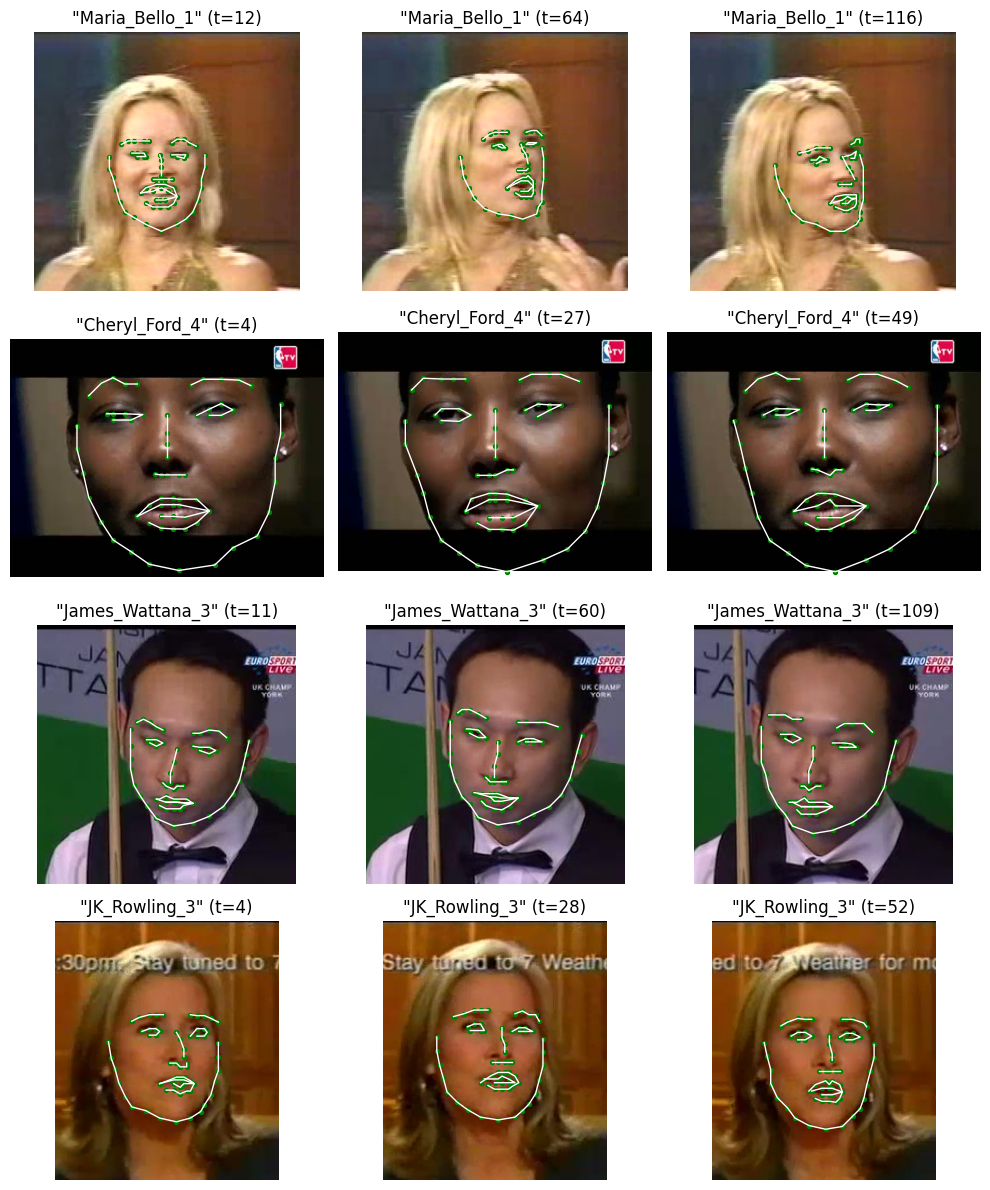

In [13]:
fig, axes = plt.subplots(nrows=numVideos, ncols=numFramesPerVideo, figsize=(10,12))

for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages'] # arrays of the image colour values
    landmarks2D = videoFile['landmarks2D']

    # select frames and show their content with the landmark points
    selectedFrames = (framesToShowFromVideo * colorImages.shape[3]-1).astype(int)
    for j, frameInd in enumerate(selectedFrames):
        axes[i,j].imshow(colorImages[:,:,:,frameInd])
        axes[i,j].scatter(x=landmarks2D[:,0,frameInd], y=landmarks2D[:,1,frameInd], s=8, c='g')
        
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks2D[conPts[0]:conPts[-1], 0, frameInd]
            yPts = landmarks2D[conPts[0]:conPts[-1], 1, frameInd]
            axes[i,j].plot(xPts, yPts, c='w', lw=1)

        axes[i,j].set_title(f'"{videoID}" (t={frameInd})')
        axes[i,j].set_axis_off()

plt.tight_layout()        
plt.show()

# Show 3D Keypoints

### This package also allows you to view the facial recognition markers in 3D

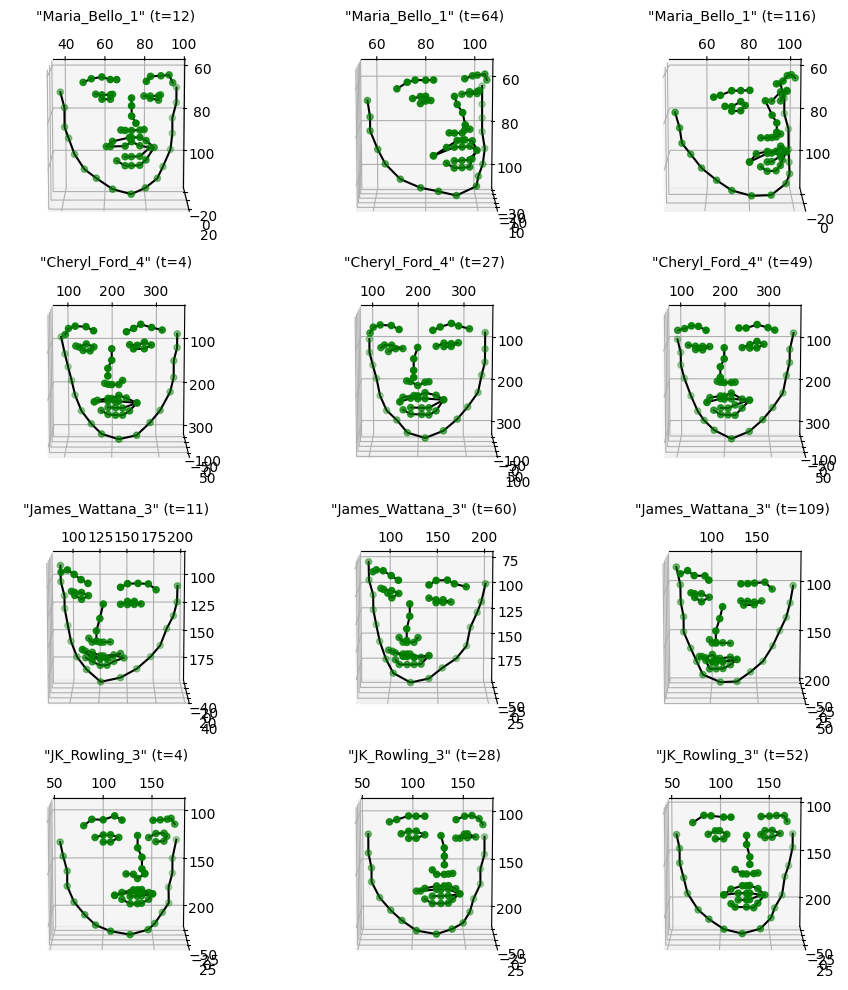

In [14]:
fig = plt.figure(figsize=(10,10))

for i, videoID in enumerate(randVideoIDs):
    # load video
    videoFile = np.load(fullPaths[videoID])
    colorImages = videoFile['colorImages'] # arrays of the image colour values
    landmarks3D = videoFile['landmarks3D']

    # select frames and show their content with the landmark points
    selectedFrames = (framesToShowFromVideo * colorImages.shape[3]-1).astype(int)

    for j, frameInd in enumerate(selectedFrames):
        subplotInd = i*numFramesPerVideo + j+1
        ax = fig.add_subplot(numVideos, numFramesPerVideo, subplotInd, projection='3d')
        ax.scatter(landmarks3D[:,0,frameInd], landmarks3D[:,1,frameInd], landmarks3D[:,2,frameInd], c='g')
        
        for conPts in listOfAllConnectedPoints:
            xPts = landmarks3D[conPts[0]:conPts[-1], 0, frameInd]
            yPts = landmarks3D[conPts[0]:conPts[-1], 1, frameInd]
            zPts = landmarks3D[conPts[0]:conPts[-1], 2, frameInd]
            ax.plot3D(xPts, yPts, zPts, c='black')
            ax.view_init(elev=100, azim=90)
            ax.set_xlim(ax.get_xlim()[::-1])
            ax.set_title(f'"{videoID}" (t={frameInd})', fontsize=10)
            
plt.tight_layout()

# Define a utility function to Create a 3D animation

#### This is essentially the same code in DrGuillermo's 3D Animation Script, only I've wrapped it with a function and added a bounding box drawing in order to avoid plotly's automatic rescaling of the axes, thus creating a contious scene and a feeling of a face moving around that scene.

In [26]:
# define a utility function to show 3D animation
def ShowAnimation_3D(landmarks3D):
    
    landmarks3D = landmarks3D.copy()
    landmarks3D[:,0,:] = -landmarks3D[:,0,:]
    
    xMin = landmarks3D[:,0,:].min()-5
    xMax = landmarks3D[:,0,:].max()+5
    yMin = landmarks3D[:,1,:].min()-5
    yMax = landmarks3D[:,1,:].max()+5
    zMin = landmarks3D[:,2,:].min()-5
    zMax = landmarks3D[:,2,:].max()+5
    
    boxCorners = np.array([[xMin,yMin,zMin],
                           [xMin,yMin,zMax],
                           [xMin,yMax,zMin],
                           [xMin,yMax,zMax],
                           [xMax,yMin,zMin],
                           [xMax,yMin,zMax],
                           [xMax,yMax,zMin],
                           [xMax,yMax,zMax]])
    
    traversalOrder = [0,1,3,2,0,4,6,2,6,7,3,7,5,1,5,4]
    boxTraceCoords = np.zeros((len(traversalOrder),3))
    for i, corner in enumerate(traversalOrder):
        boxTraceCoords[i,:] = boxCorners[corner,:]
    
    trace1   = go.Scatter3d(name='Jawline', x=landmarks3D[:,0,1][0:17],y=landmarks3D[:,1,1][0:17],z=landmarks3D[:,2,1][0:17],
                            mode='lines+markers',marker=dict(color = 'blue',opacity=0.7,size = 5))
    
    trace2   = go.Scatter3d(name='Right Eyebrow',x=landmarks3D[:,0,1][17:22],y=landmarks3D[:,1,1][17:22],z=landmarks3D[:,2,1][17:22],
                            mode='lines+markers',marker=dict(color = 'blue',opacity=0.7,size = 5))
    
    trace3   = go.Scatter3d(name='Left Eyebrow',x=landmarks3D[:,0,1][22:27],y=landmarks3D[:,1,1][22:27],z=landmarks3D[:,2,1][22:27],
                            mode='lines+markers',marker=dict(color = 'blue',opacity=0.7,size = 5))
    
    trace4   = go.Scatter3d(name='Nose Ridge',x=landmarks3D[:,0,1][27:31],y=landmarks3D[:,1,1][27:31],z=landmarks3D[:,2,1][27:31],
                            mode='lines+markers',marker=dict(color = 'green',opacity=0.6,size = 5))
    
    trace5   = go.Scatter3d(name='Nose Base',x=landmarks3D[:,0,1][31:36],y=landmarks3D[:,1,1][31:36],z=landmarks3D[:,2,1][31:36],
                            mode='lines+markers',marker=dict(color = 'green',opacity=0.6,size = 5))
    
    trace6   = go.Scatter3d(name='Right Eye', x=landmarks3D[:,0,1][36:42],y=landmarks3D[:,1,1][36:42],z=landmarks3D[:,2,1][36:42],
                            mode='lines+markers',marker=dict(color = 'green',opacity=0.6,size = 5))
    
    trace7   = go.Scatter3d(name='Left Eye', x=landmarks3D[:,0,1][42:48],y=landmarks3D[:,1,1][42:48],z=landmarks3D[:,2,1][42:48],
                            mode='lines+markers',marker=dict(color = 'green',opacity=0.6,size = 5))
    
    trace8   = go.Scatter3d(name='Outer Mouth', x=landmarks3D[:,0,1][48:60],y=landmarks3D[:,1,1][48:60],z=landmarks3D[:,2,1][48:60],
                            mode='lines+markers',marker=dict(color = 'green',opacity=0.6,size = 5))
    
    trace9   = go.Scatter3d(name='Inner Mouth', x=landmarks3D[:,0,1][60:68],y=landmarks3D[:,1,1][60:68],z=landmarks3D[:,2,1][60:68],
                            mode='lines+markers',marker=dict(color = 'green',opacity=0.6,size = 5))
        
    boxTrace = go.Scatter3d(name='boundingBox', x=boxTraceCoords[:,0],y=boxTraceCoords[:,1],z=boxTraceCoords[:,2],
                            mode='lines+markers',marker=dict(color = 'red', opacity=1.0,size = 5))
    
    data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8, trace9, boxTrace]
    
    mfr = []
    for t in range(len(landmarks3D[1,1,:])):
        mfr.append({'data' :[{'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][ 0:17],'y':landmarks3D[:,1,t][0:17],'z':landmarks3D[:,2,t][ 0:17]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][17:22],'y':landmarks3D[:,1,t][17:22],'z':landmarks3D[:,2,t][17:22]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][22:27],'y':landmarks3D[:,1,t][22:27],'z':landmarks3D[:,2,t][22:27]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][27:31],'y':landmarks3D[:,1,t][27:31],'z':landmarks3D[:,2,t][27:31]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][31:36],'y':landmarks3D[:,1,t][31:36],'z':landmarks3D[:,2,t][31:36]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][36:42],'y':landmarks3D[:,1,t][36:42],'z':landmarks3D[:,2,t][36:42]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][42:48],'y':landmarks3D[:,1,t][42:48],'z':landmarks3D[:,2,t][42:48]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][48:60],'y':landmarks3D[:,1,t][48:60],'z':landmarks3D[:,2,t][48:60]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                              'x':landmarks3D[:,0,t][60:68],'y':landmarks3D[:,1,t][60:68],'z':landmarks3D[:,2,t][60:68]},
                             {'type' : "scatter3d",'mode':'lines+markers',
                             'x':boxTraceCoords[:,0],'y':boxTraceCoords[:,1],'z':boxTraceCoords[:,2]}]})
                                 
    
    layout = go.Layout(width=800, height=800, title='3D Face Shape Animation',
                       scene=dict(camera=dict(up     = dict(x= 0, y=-1.0, z=0),
                                              center = dict(x= 0, y= 0.0, z=0),
                                              eye    = dict(x= 0, y= 0.7, z=2),
                                             )
                                 ),
                        updatemenus=[dict(type='buttons', showactive=False,
                                            y=1,
                                            x=1,
                                            xanchor='right',
                                            yanchor='top',
                                            pad=dict(t=0, r=10),
                                            buttons=[dict(
                                                        label='Play Animation',
                                                        method='animate',
                                                        args=[None, dict(frame       = dict(duration=0.04, redraw=True), 
                                                                         transition  = dict(duration=0),
                                                                         fromcurrent = True,
                                                                         mode = 'immediate'
                                                                        )
                                                             ]
                                                         )
                                                    ]
                                           )
                                      ]
                      )
                                                    
    fig = dict(data=data, layout=layout, frames=mfr)
    py.iplot(fig)

# Load a Video and Present it's 3D keypoint Animation

### Press the "Play Animation" button to play a nice and fast animation, don't wait for the automatic animation to finish (it's too slow)

In [27]:
# load a 3D landmarks sequence and present it
personToUse = 'Maria_Bello_1'
videoFile = np.load(fullPaths[personToUse])
landmarks3D_curr = videoFile['landmarks3D']

ShowAnimation_3D(landmarks3D_curr)

# Normalize 2D and 3D shapes

### Collect all 2D and 3D shapes from all frames from all videos to a single numpy array matrix

In [15]:
# total number of frames 
totalNumberOfFrames = videoDF['videoDuration'].sum().astype(int)
print(f'Total number of frames in dataset: {totalNumberOfFrames}')

#Initialize arrarys for the landmark points for each frame in the dataset
landmarks2D_all = np.zeros((68, 2, totalNumberOfFrames))
landmarks3D_all = np.zeros((68, 3, totalNumberOfFrames))


shapeIndToVideoID = {} # dictionary for later usage
endInd = 0

# Add the frames to the arrays
for i, videoID in enumerate(videoDF['videoID']):

    # load video
    videoFile = np.load(fullPaths[videoID])
    landmarks2D = videoFile['landmarks2D']
    landmarks3D = videoFile['landmarks3D']

    startInd = endInd
    endInd = startInd + landmarks2D.shape[2]

    # store in one big array
    landmarks2D_all[:,:,startInd:endInd] = landmarks2D
    landmarks3D_all[:,:,startInd:endInd] = landmarks3D

    # make sure we keep track of the mapping to the original video and frame
    for videoFrameInd, shapeInd in enumerate(range(startInd,endInd)):
        shapeIndToVideoID[shapeInd] = (videoID, videoFrameInd)

print(landmarks2D_all.shape)
print(landmarks3D_all.shape)

Total number of frames in dataset: 260399
(68, 2, 260399)
(68, 3, 260399)


### Normalize the landmarks so they can be compared

In [16]:
# center the shapes around zero
# i.e. such that for each frame the mean x,y,z coordinates will be zero
# or in math terms: Xc = X - mean(X), Yc = Y - mean(Y), Zc = Z - mean(Z)
landmarks2D_centered = np.zeros(landmarks2D_all.shape)
landmarks2D_centered = landmarks2D_all - np.tile(landmarks2D_all.mean(axis=0), [68,1,1])

landmarks3D_centered = np.zeros(landmarks3D_all.shape)
landmarks3D_centered = landmarks3D_all - np.tile(landmarks3D_all.mean(axis=0), [68,1,1])

# normalize the shapes such that they have the same scale
# i.e. such that for each frame the mean euclidian distance from the shape center will be one
# or in math terms: mean( sqrt(dX^2 + dY^2 + dZ^2) ) = 1
landmarks2D_normalized = np.zeros(landmarks2D_all.shape)
landmarks2D_normalized = landmarks2D_centered / np.tile((np.sqrt((landmarks2D_centered**2).sum(axis=1))).mean(axis=0), [68,2,1])

landmarks3D_normalized = np.zeros(landmarks3D_all.shape)
landmarks3D_normalized = landmarks3D_centered / np.tile((np.sqrt((landmarks3D_centered**2).sum(axis=1))).mean(axis=0), [68,3,1])

# Visualize 2D Shape Normalization stages

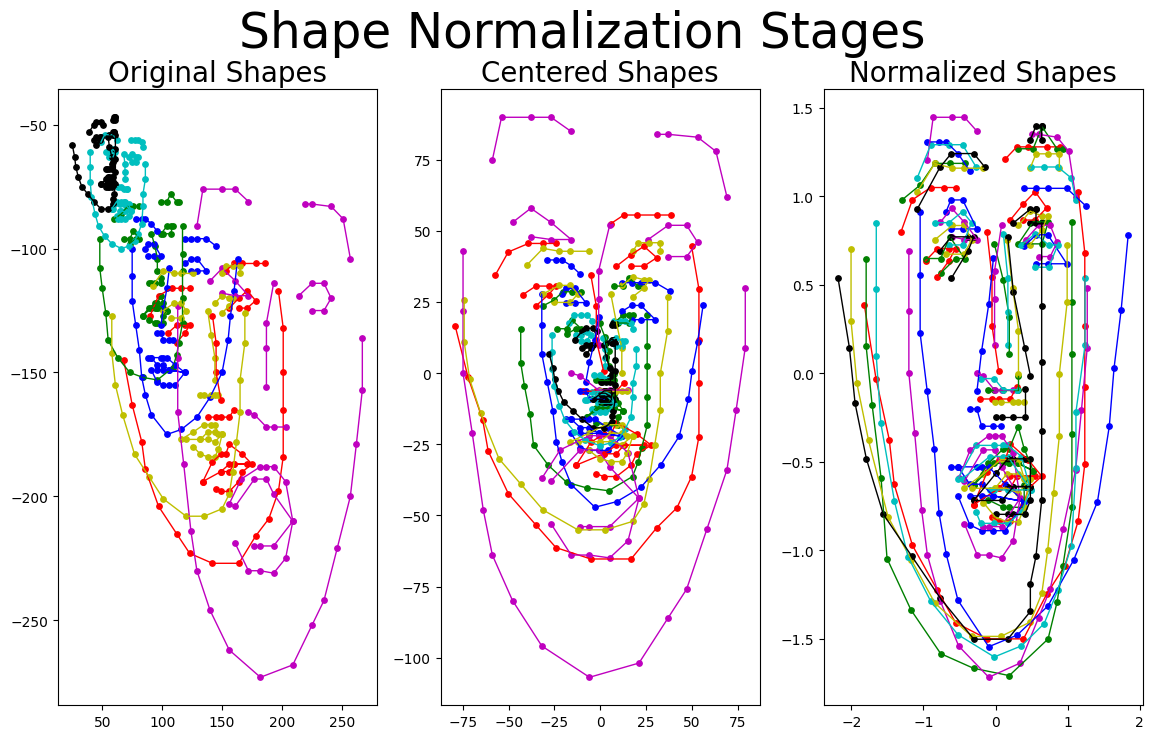

In [44]:
# check the 2D normalization and verify that everything is as expected
# select random several frames to be used as test cases
np.random.seed(23)

listOfShapeColors = ['r','g','b','m','y','c','k']
numShapesToPresent = len(listOfShapeColors)
listOfShapeInds = np.random.choice(range(int(totalNumberOfFrames)), size=numShapesToPresent, replace=False)

plt.figure(figsize=(14,8))
plt.suptitle('Shape Normalization Stages',fontsize=35) # main figure box setup and title

# original shapes
plt.subplot(1,3,1)
for i, shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_all[:,0,shapeInd], -landmarks2D_all[:,1,shapeInd], s=15, c=listOfShapeColors[i])
    for conPts in listOfAllConnectedPoints:
        xPts = landmarks2D_all[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_all[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts, yPts, c=listOfShapeColors[i], lw=1)
# plt.axis('off')
plt.title('Original Shapes', fontsize=20)

# centered shapes
plt.subplot(1,3,2)
for i, shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_centered[:,0,shapeInd], -landmarks2D_centered[:,1,shapeInd], s=15, c=listOfShapeColors[i])
    for conPts in listOfAllConnectedPoints:
        xPts = landmarks2D_centered[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_centered[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts, yPts, c=listOfShapeColors[i], lw=1)
# plt.axis('off')
plt.title('Centered Shapes', fontsize=20)

# normalized shapes
plt.subplot(1,3,3)
for i, shapeInd in enumerate(listOfShapeInds):
    plt.scatter(landmarks2D_normalized[:,0,shapeInd], -landmarks2D_normalized[:,1,shapeInd], s=15, c=listOfShapeColors[i])
    for conPts in listOfAllConnectedPoints:
        xPts = landmarks2D_normalized[conPts[0]:conPts[-1],0,shapeInd]
        yPts = -landmarks2D_normalized[conPts[0]:conPts[-1],1,shapeInd]
        plt.plot(xPts, yPts, c=listOfShapeColors[i], lw=1)
# plt.axis('off')
plt.title('Normalized Shapes', fontsize=20)
plt.show()